3
[0, 1, 0]
2 0
max 2
1 1
0 0


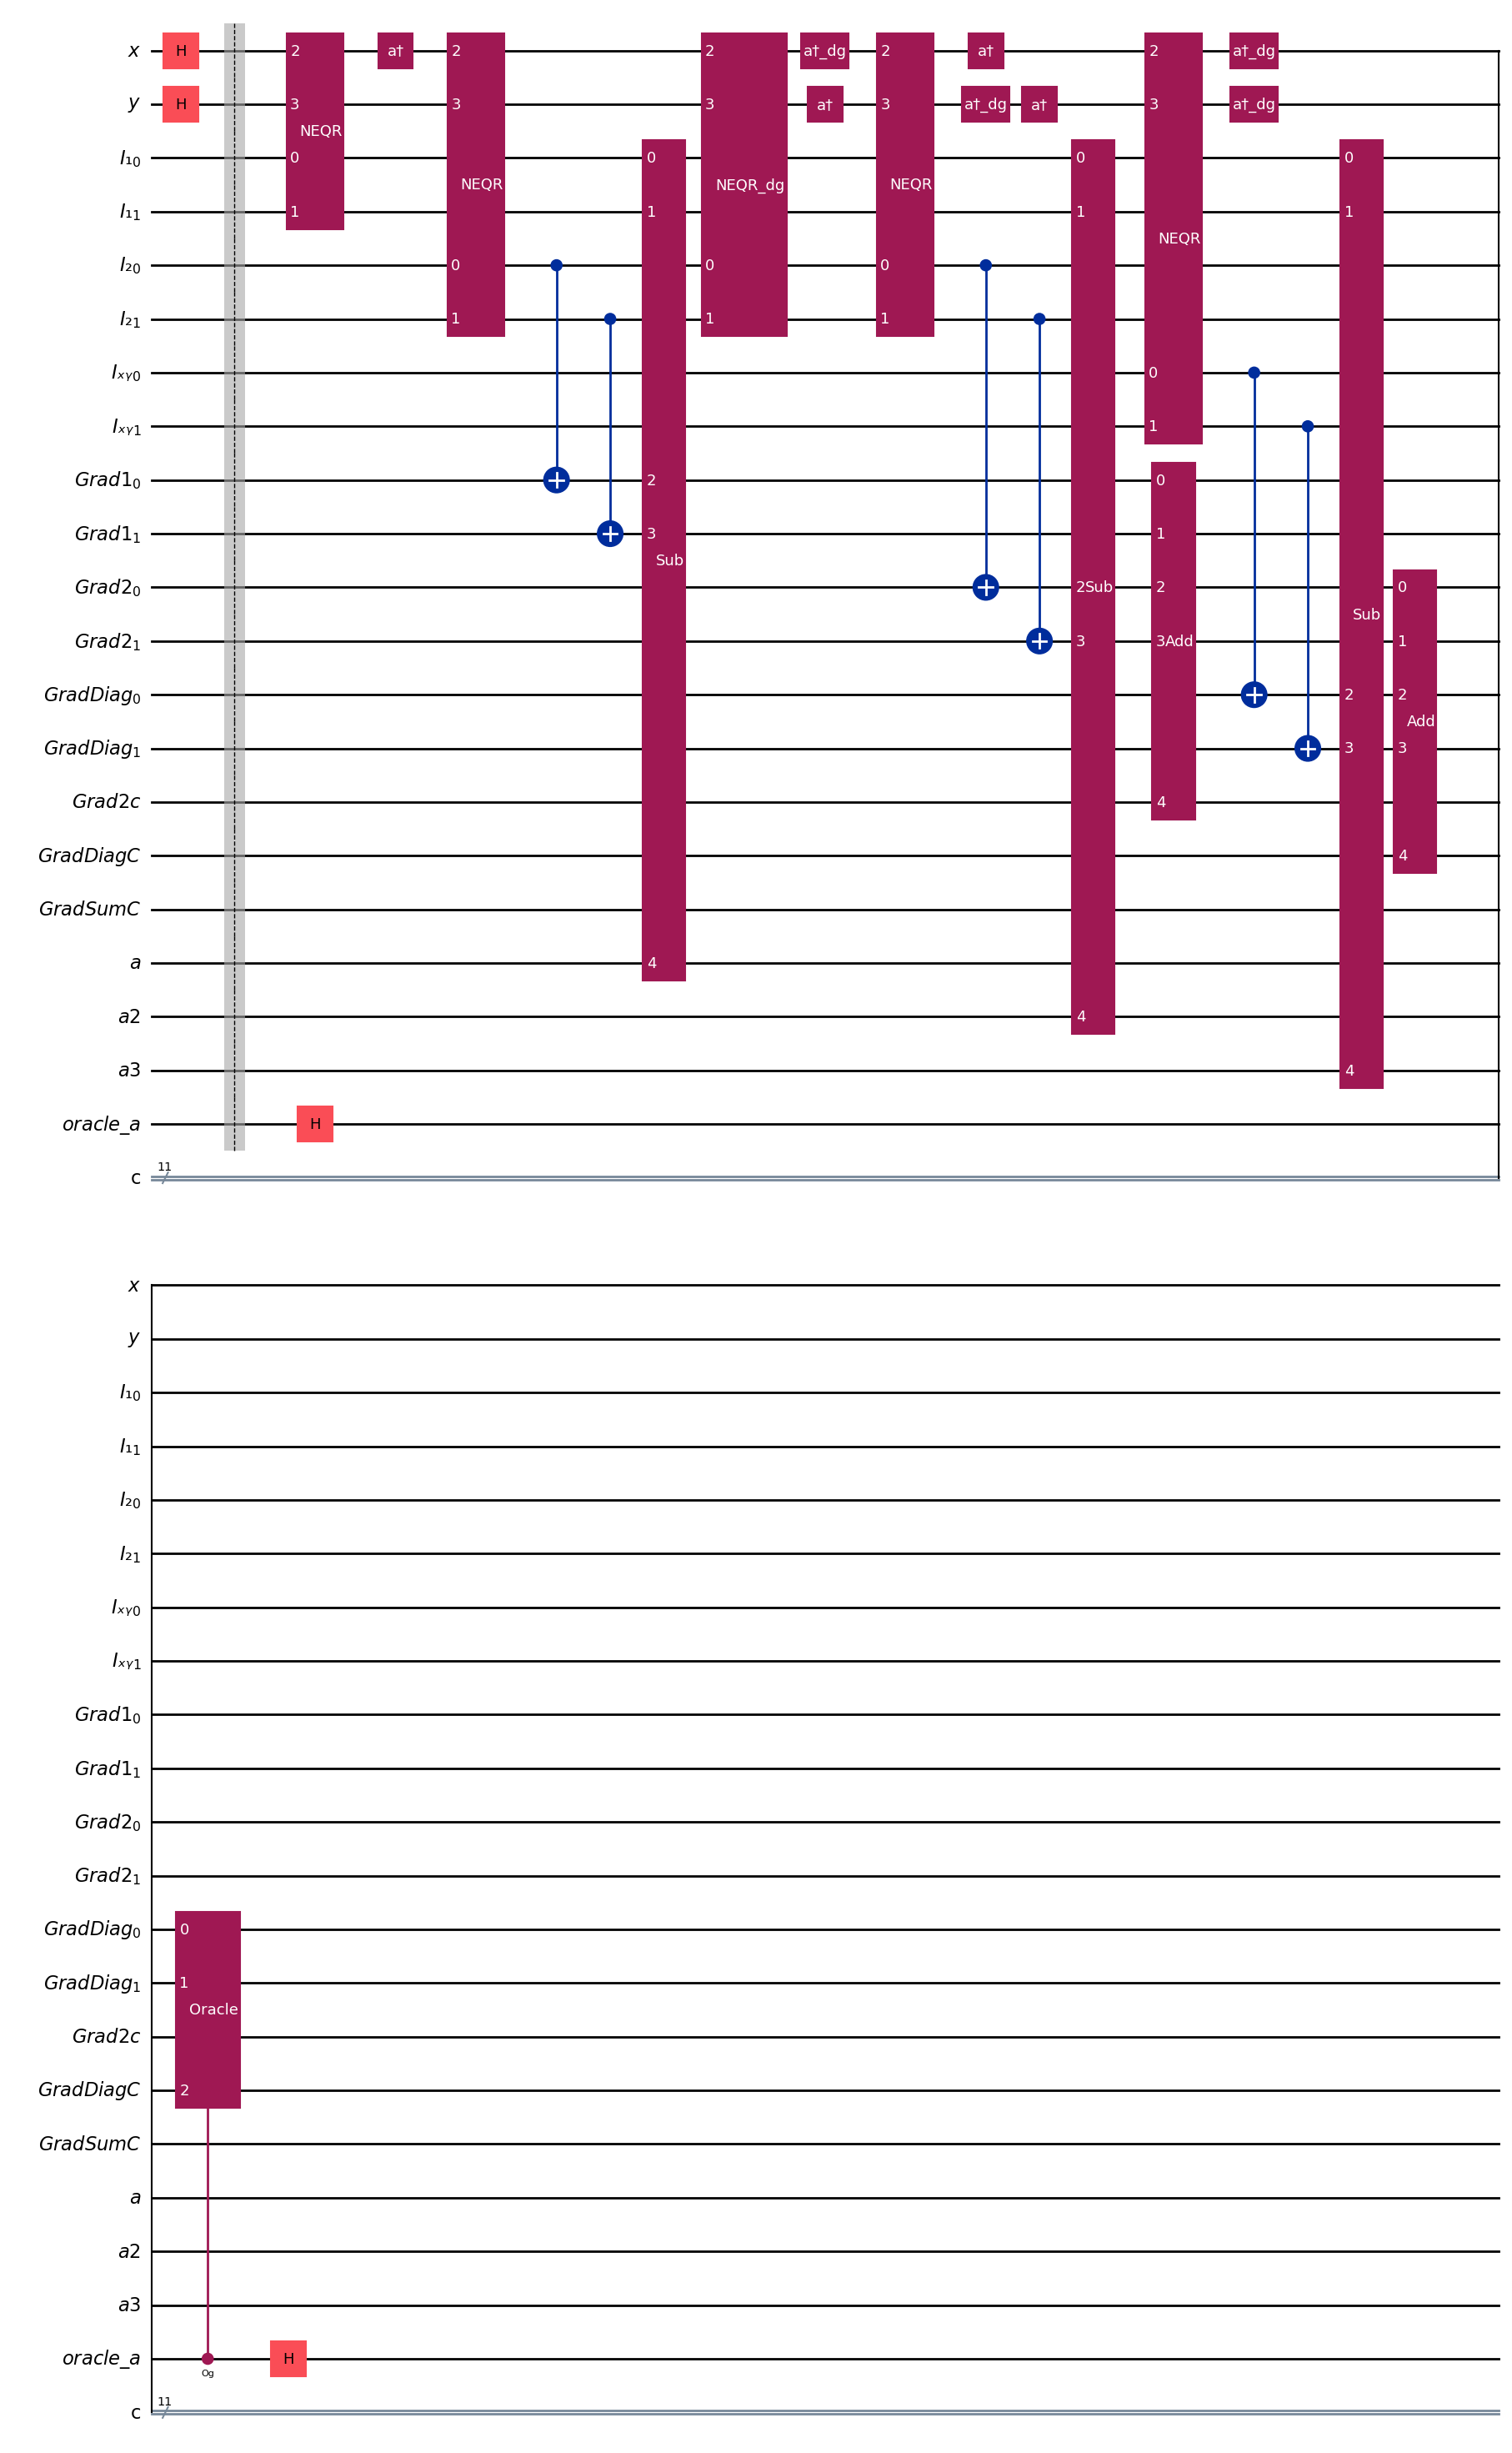

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFTGate  
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library.basis_change import QFT
from neqr import neqr
from ladder import ladder_up
from enhanced_grover import filter_oracle
from qsubtract import subtract
from qadd import qft_adder

num_bits = 1
intensity_bits =  2

image = np.array([
    [0, 1],
    [3, 2]
])

x = QuantumRegister(num_bits, name='x')
y = QuantumRegister(num_bits, name='y')
i1 = QuantumRegister(intensity_bits, name='I₁')
i2 = QuantumRegister(intensity_bits, name='I₂')
ixy = QuantumRegister(intensity_bits, name='Iₓᵧ')
grad1 = QuantumRegister(intensity_bits, name='Grad1')
grad2 = QuantumRegister(intensity_bits, name='Grad2')
grad_diag = QuantumRegister(intensity_bits, name='GradDiag')
grad2c = QuantumRegister(1, name='Grad2c')
grad_diag_c = QuantumRegister(1, name='GradDiagC')
grad_sum_c = QuantumRegister(1, name='GradSumC')
anc = QuantumRegister(1, name='a')
anc2 = QuantumRegister(1, name = 'a2')
anc3 = QuantumRegister(1, name = 'a3')
oracle_a = QuantumRegister(1, name = 'oracle_a')
cr = ClassicalRegister(num_bits*2 + intensity_bits + 7, name='c')

qc = QuantumCircuit(x, y, i1, i2, ixy, grad1, grad2, grad_diag, grad2c, grad_diag_c, grad_sum_c, anc, anc2, anc3, oracle_a, cr)

qc.h(x)
qc.h(y)
qc.barrier()

neqr_gate = neqr(i1, x, y, image)
qc.append(neqr_gate, list(i1) + list(x) + list(y))

# Shift x up and encode to i2
ladder_x = ladder_up(x)
qc.append(ladder_x, list(x))
qc.append(neqr_gate, list(i2) + list(x) + list(y))

# Subtract i2 - i1 => grad1
for i in range(intensity_bits):
    qc.cx(i2[i], grad1[i])
sub1 = subtract(i1, grad1, anc)
qc.append(sub1, list(i1) + list(grad1) + list(anc))

# Undo ladder x and re-encode i2 for y shift
qc.append(neqr_gate.inverse(), list(i2) + list(x) + list(y))
qc.append(ladder_x.inverse(), list(x))
ladder_y = ladder_up(y)
qc.append(ladder_y, list(y))
qc.append(neqr_gate, list(i2) + list(x) + list(y))
qc.append(ladder_y.inverse(), list(y))

# Subtract i2 - i1 => grad2
for i in range(intensity_bits):
    qc.cx(i2[i], grad2[i])
qc.append(sub1, list(i1) + list(grad2) + list(anc2))

# Sum grad1 + grad2 => grad2
add_xy = qft_adder(grad1, grad2, grad2c)
qc.append(add_xy, list(grad1) + list(grad2) + list(grad2c))

# Diagonal: shift x and y up, encode ixy
qc.append(ladder_x, list(x))
qc.append(ladder_y, list(y))
qc.append(neqr_gate, list(ixy) + list(x) + list(y))
qc.append(ladder_x.inverse(), list(x))
qc.append(ladder_y.inverse(), list(y))

# Subtract ixy - i1 => grad_diag
for i in range(intensity_bits):
    qc.cx(ixy[i], grad_diag[i])
qc.append(sub1, list(i1) + list(grad_diag) + list(anc3))

# Sum with grad2 => grad_diag
add_diag = qft_adder(grad2, grad_diag, grad_diag_c)
qc.append(add_diag, list(grad2) + list(grad_diag) + list(grad_diag_c))

# Grover threshold oracle
qc.h(oracle_a)
oracle = filter_oracle("010")
cog = oracle.control(1, label="Og")
qc.append(cog, list(oracle_a) + list(grad_diag) + list(grad_diag_c))
qc.h(oracle_a)

# Final measurement
#qc.measure(list(x) + list(y) + list(i1) + list(grad1) + list(grad2) + list(grad2c) + list(grad_diag) + list(grad_diag_c) + list(oracle_a), list(cr))

qc.draw('mpl')
